# Вступ
Сан-Франциско був сумно відомий тим, що на острові Алькатрас були ув'язнені найвідоміші злочинці у світі. Сьогодні місто відоме більше своєю технологічністю, ніж своїм кримінальним минулим. Цей проект аналізує 12-річні повідомлення про злочини з усіх районів Сан-Франциско, щоб створити модель, яка передбачить категорію злочину, що стався, враховуючи час і місце. 
# Визначення
## Огляд проекту 
У сучасній історії Сполучених Штатів рівень злочинності зріс після Другої світової війни, досягнувши свого піку з 1970-х до початку 1990-х. За період з 1960 р. До свого піку в 1991 р. Насильницькі злочини зросли майже в чотири рази. Злочинність за власність зросла більш ніж удвічі за той самий період. Однак з 1990-х років злочинність у Сполучених Штатах стабільно зменшується.
## Постановка проблеми
Для вивчення конкретної проблеми ми застосуємо повний життєвий цикл Data Science, що складається з наступних кроків:
1. Перебіг даних, щоб перевірити якість даних та виконати всі необхідні дії для очищення набору даних.
2. Дослідження даних для розуміння змінних та створення інтуїції даних.
3. Функціональна інженерія для створення додаткових змінних з існуючих.
4. Нормалізація даних та перетворення даних для підготовки набору даних для алгоритмів навчання (за потреби).
5. Навчання / тестування створення даних для оцінки продуктивності наших моделей та тонкої настройки їх гіперпараметрів.
6. Вибір та оцінка моделі. Це буде кінцевою метою; створення моделі, яка передбачає ймовірність кожного виду злочину на основі місця та дати.

## Метрики
Найбільш підходящою метрикою оцінки для таких задач є **багатокласова логарифмічна втрата** . Логарифмічні втрати вимірюють ефективність класифікаційної моделі, де вихідним прогнозом є значення ймовірності від 0 до 1. Для кожного інциденту ми передбачимо набір прогнозованих ймовірностей (по одному для кожного класу) і обчислимо середнє відхилення від реальні цінності.
Щоб отримати трохи більше інтуїції щодо метрики для конкретного випадку:
* Ми отримуємо 0 втрат від категорій злочинів, які не сталися (оскільки yij = 0 yijlog (pij)) незалежно від нашої передбачуваної ймовірності.
* Ми отримуємо log (pij) втрати з тієї категорії, яка сталася, де pij - це наша прогнозована ймовірність для конкретної категорії.

Тут ми повинні зазначити, що оскільки всі ймовірності для конкретного інциденту складають 1, кожна ймовірність, яку ми прогнозуємо для категорії, яка не сталася, створює «непряму» втрату, оскільки зменшує нашу прогнозовану ймовірність для категорії злочину, що стався.
Іншими словами, метрика оцінює визначеність нашої моделі для кожної категорії злочинів / інцидентів.

# Аналіз  
## Дослідження даних 
Набір даних представлений у вигляді таблиці та включає хронологічні, географічні та текстові дані та містить випадки, отримані за допомогою системи звітності про злочинні ситуації SFPD.

In [1]:
! pip install contextily
import pandas as pd
from shapely.geometry import  Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import cm
import urllib.request
import shutil
import zipfile
import os
import re
import contextily as ctx
import geoplot as gplt
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import shap

You are using pip version 18.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
train = pd.read_csv('../input/train.csv.zip', parse_dates=['Dates'])
test = pd.read_csv('../input/test.csv.zip', parse_dates=['Dates'], index_col='Id')

In [3]:
print('First date: ', str(train.Dates.describe()['first']))
print('Last date: ', str(train.Dates.describe()['last']))
print('Test data shape ', train.shape)

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00
Test data shape  (878049, 9)


Дані варіюються від 1/1/2003 до 5/13/2015 створення навчального набору даних з дев’ятьма функціями та 878049 зразками

In [4]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


* X - довгота
* Y - широта

In [5]:
train.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

Набір даних містить багато змінних типу object ті самі string, які нам потрібно буде кодувати

In [6]:
train.duplicated().sum()

2323

Він також містить 2323 дублікати, які нам слід видалити.
Ми також оцінимо положення точок даних за допомогою координат.

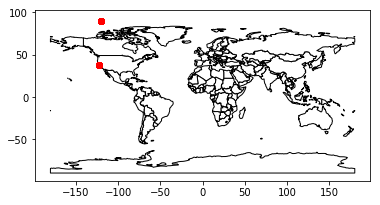

In [7]:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

Деякі пункти втрачені. Давайте подивимося, скільки їх.

In [8]:
print(train_gdf.loc[train_gdf.Y > 50].count()[0])
train_gdf.loc[train_gdf.Y > 50].sample(5)

67


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Coordinates
678540,2005-10-03 18:46:00,NON-CRIMINAL,PROPERTY FOR IDENTIFICATION,Monday,TENDERLOIN,"ARREST, CITED",7THSTNORTH ST / MCALLISTER ST,-120.5,90.0,POINT (-120.5 90)
871198,2003-02-05 12:00:00,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Wednesday,SOUTHERN,NONE,SPEAR ST / THE EMBARCADERO SOUTH ST,-120.5,90.0,POINT (-120.5 90)
845842,2003-06-09 09:25:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0,POINT (-120.5 90)
823378,2003-09-21 13:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,BAYVIEW,NONE,GILMAN AV / FITCH ST,-120.5,90.0,POINT (-120.5 90)
677036,2005-10-07 08:35:00,NON-CRIMINAL,FOUND PROPERTY,Friday,TENDERLOIN,UNFOUNDED,7THSTNORTH ST / MCALLISTER ST,-120.5,90.0,POINT (-120.5 90)


Ми замінимо віддалені координати на середні координати району, до якого вони належать.

In [10]:
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])

train_gdf = create_gdf(train)

Після очищення набору даних від дублікатів ми досліджуємо змінні.
### Дати та дні тижня
Ці змінні розподіляються рівномірно в період з 01.01.2003 по 13.05.2015 (з понеділка по неділю) та розподіляються між тренуванням та набором даних тестування, як згадувалося раніше.
Середня частота інцидентів становить 389 на добу при стандартному відхиленні 48,51.

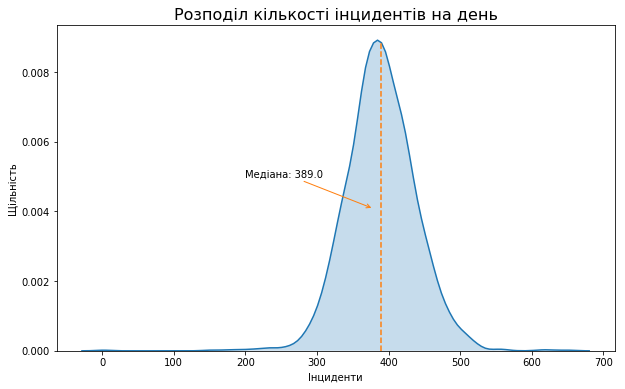

In [11]:
col = sns.color_palette()

train['Date'] = train.Dates.dt.date
train['Hour'] = train.Dates.dt.hour

plt.figure(figsize=(10, 6))
data = train.groupby('Date').count().iloc[:, 0]
sns.kdeplot(data=data, shade=True)
plt.axvline(x=data.median(), ymax=0.95, linestyle='--', color=col[1])
plt.annotate(
    'Медіана: ' + str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))
plt.title(
    'Розподіл кількості інцидентів на день', fontdict={'fontsize': 16})
plt.xlabel('Інциденти')
plt.ylabel('Щільність')
plt.legend().remove()
plt.show()

Крім того, протягом тижня не спостерігається значних відхилень частоти інцидентів. Таким чином, ми не очікуємо, що ця змінна відіграватиме значну роль у прогнозуванні.

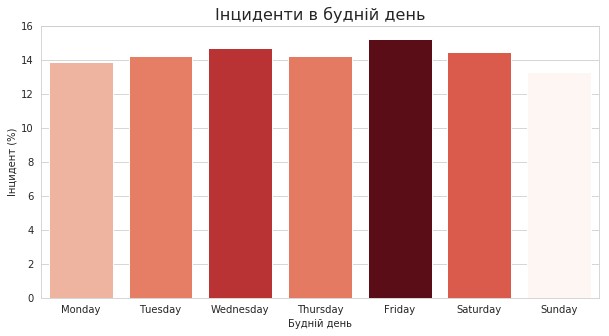

In [12]:
data = train.groupby('DayOfWeek').count().iloc[:, 0]
data = data.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
])

plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        data.index, (data.values / data.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Reds').to_rgba(data.values))

plt.title('Інциденти в будній день', fontdict={'fontsize': 16})
plt.xlabel('Будній день')
plt.ylabel('Інцидент (%)')

plt.show()

### Категорія
Існує 39 дискретних категорій, за якими відділ поліції подає інциденти, серед яких найпоширенішими є «злочин / крадіжка» (19,91%), «не кримінальні» (10,50%) та напад (8,77%).

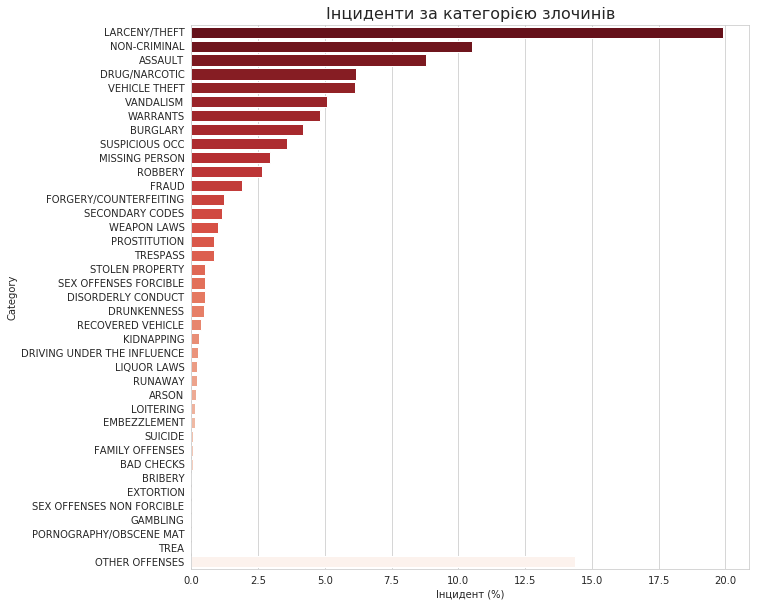

In [13]:
data = train.groupby('Category').count().iloc[:, 0].sort_values(
    ascending=False)
data = data.reindex(np.append(np.delete(data.index, 1), 'OTHER OFFENSES'))

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        (data.values / data.values.sum()) * 100,
        data.index,
        orient='h',
        palette="Reds_r")

plt.title('Інциденти за категорією злочинів', fontdict={'fontsize': 16})
plt.xlabel('Інцидент (%)')

plt.show()

### Поліцейський округ
Існують суттєві відмінності між різними районами міста, причому найбільше інцидентів має Південний район (17,87%), а потім Mission (13,67%) та Північний (12,00%).

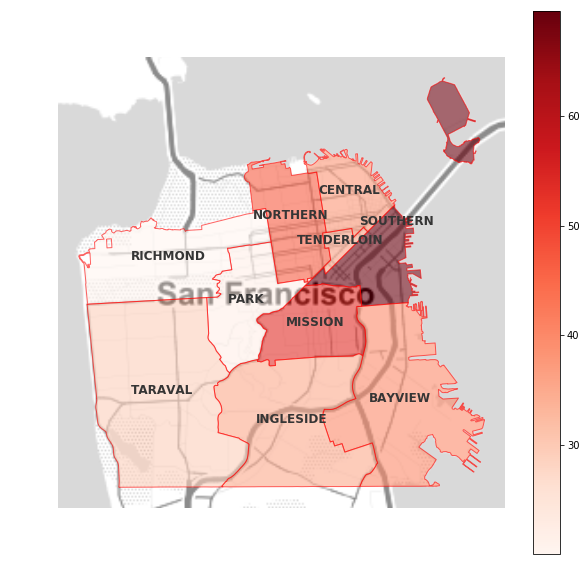

In [14]:
# Завантаження шейп-файлу області
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
# Unzipping it
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')
# Loading to a geopandas dataframe
for filename in os.listdir('./pd_data/'):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        break
# Defining the coordinate system to longitude/latitude
pd_districts.crs={'init': 'epsg:4326'}

# Merging our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    train.groupby('PdDistrict').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    how='inner',
    left_on='district',
    right_index=True,
    suffixes=('_x', '_y'))

# Transforming the coordinate system to Spherical Mercator for
# compatibility with the tiling background
pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})

# Calculating the incidents per day for every district
train_days = train.groupby('Date').count().shape[0]
pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

# Ploting the data
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()

### Адреса
Адреса як текстове поле вимагає вдосконалених методів, щоб використовувати її для прогнозування. Натомість у цьому проекті ми будемо використовувати його для видобутку, якщо інцидент стався на дорозі чи в будівельному блоці.
### X - довгота Y - широта
Ми перевірили, що координати знаходяться в межах міста. Хоча довгота не містить жодних відхилень, широта включає близько 90o значень, які відповідають Північному полюсу.
## Дослідницька візуалізація
На основі заяви Проекту нам потрібно передбачити ймовірність кожного виду злочину, виходячи з часу та місця знаходження. З огляду на це, ми представляємо дві діаграми, щоб продемонструвати важливість цих змінних. Перший представляє географічну щільність 9 категорій випадкових злочинів. Ми бачимо, що хоча епіцентр більшості злочинів знаходиться на північному сході міста, кожен злочин має різну щільність в решті міста. Цей факт є надійним свідченням того, що місцезнаходження (координати / поліцейський округ) буде важливим фактором для аналізу та прогнозування.


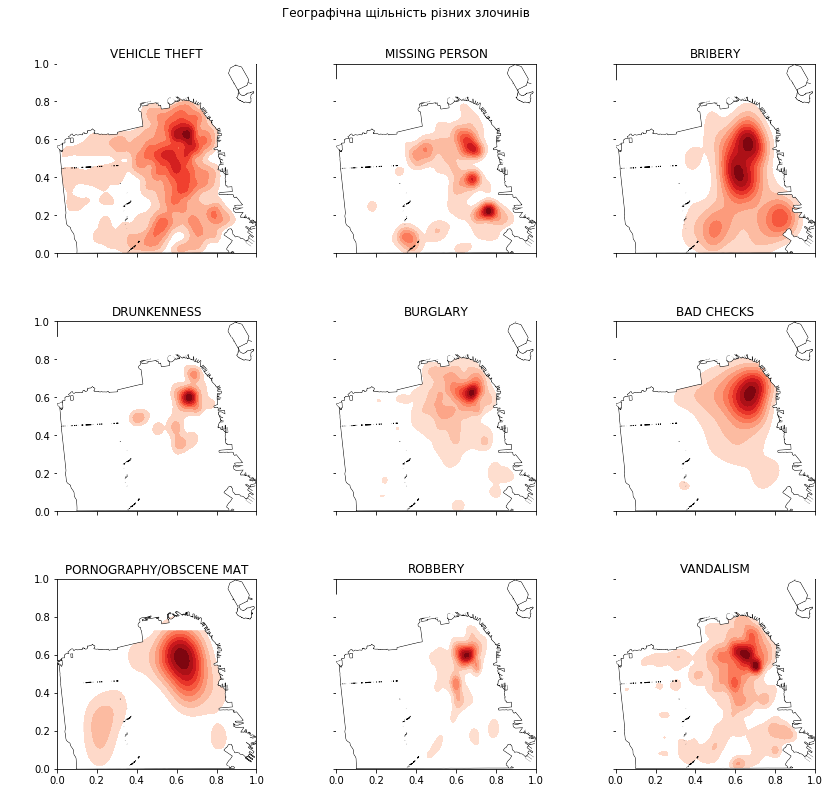

In [15]:
crimes = train['Category'].unique().tolist()
crimes.remove('TREA')

pd_districts = pd_districts.to_crs({'init':'epsg:4326'})
sf_land = pd_districts.unary_union
sf_land = gpd.GeoDataFrame(gpd.GeoSeries(sf_land), crs={'init':'epsg:4326'})
sf_land = sf_land.rename(columns={0:'geometry'}).set_geometry('geometry')

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))
for i , crime in enumerate(np.random.choice(crimes, size=9, replace=False)):
    data = train_gdf.loc[train_gdf['Category'] == crime]
    ax = fig.add_subplot(3, 3, i+1)
    gplt.kdeplot(data,
                 shade=True,
                 shade_lowest=False,
                 clip = sf_land.geometry,
                 cmap='Reds',
                 ax=ax)
    gplt.polyplot(sf_land, ax=ax)
    ax.set_title(crime) 
plt.suptitle('Географічна щільність різних злочинів')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

На діаграмі середня кількість інцидентів на годину по категоріям. Деякі приклади: проституція відбувається ввечері і всю ніч, азартні ігри починаються пізно ввечері до ранку, а крадіжки вранці і до обіду. Часові параметри грають роль.

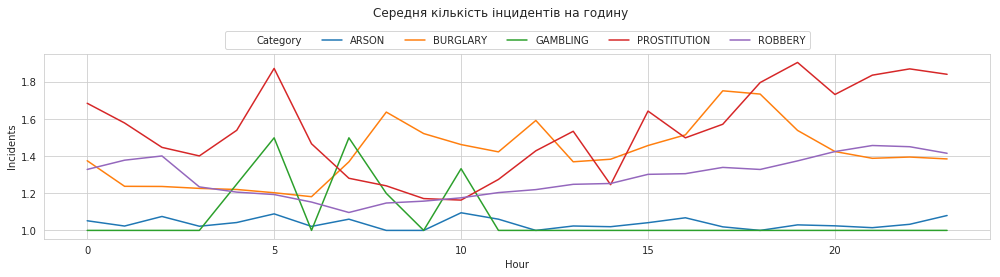

In [16]:
data = train.groupby(['Hour', 'Date', 'Category'],
                     as_index=False).count().iloc[:, :4]
data.rename(columns={'Dates': 'Incidents'}, inplace=True)
data = data.groupby(['Hour', 'Category'], as_index=False).mean()
data = data.loc[data['Category'].isin(
    ['ROBBERY', 'GAMBLING', 'BURGLARY', 'ARSON', 'PROSTITUTION'])]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 4))
ax = sns.lineplot(x='Hour', y='Incidents', data=data, hue='Category')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6)
plt.suptitle('Середня кількість інцидентів на годину')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Алгоритми та прийоми

| **Алгоритм**                | **Параметри**                                     |**Втрата фужналу**|
|:---------------------------:|:-------------------------------------------------:|:--------:|
| Stochastic Gradient Descent | Default Scikit-Learn Parameters (with 'log' loss) |  2.86631 |
| K-Nearest Neighbors         | Default Scikit-Learn Parameters                   | 23.29263 |
| Random Forest               | Default Scikit-Learn Parameters                   |  2.92716 |
| AdaBoost                    | Default Scikit-Learn Parameters                   |  3.58856 |
| XGBoost                     | Default Scikit-Learn Parameters                   |  2.91656 |
| LIghtGBM                    | Default Scikit-Learn Parameters                   |  2.98336 |  

SGD набрав найкращий початковий результат, але після тривалої настройки гіперпараметру він не зміг подолати поріг 2,54503.

Нарешті, з алгоритмів, які набрали менше 3,0, ми вирішили працювати з LightGBM завдяки його ефективності та універсальності в налаштуванні гіперпараметрів.
LightGBM - це алгоритм підсилення дерева рішень, який використовує алгоритми, засновані на гістограмах, які згрупують безперервні значення об’єкта (атрибута) у дискретні контейнери. Цей прийом прискорює навчання і зменшує використання пам'яті. У простому розумінні алгоритм працює так:

## Орієнтир
Існує два типи орієнтирів, які нам потрібно встановити. Першим буде наївне передбачення. Цей прогноз буде базовим балом для порівняння з балом нашої моделі, щоб оцінити, чи маємо якісь значні успіхи.

У багатокласовій класифікації найкращий спосіб обчислення базової лінії полягає в припущенні, що ймовірність кожної категорії дорівнює середній частоті у складі поїздів. Частоту можна легко розрахувати, розділивши суму випадків кожної категорії на кількість рядків навчального набору.


In [17]:
naive_vals = train.groupby('Category').count().iloc[:,0]/train.shape[0]
n_rows = test.shape[0]

submission = pd.DataFrame(
    np.repeat(np.array(naive_vals), n_rows).reshape(39, n_rows).transpose(),
    columns=naive_vals.index)

Базова лінія, розрахована таким чином, становить 2,68015. (Details in [SF-Crime Analysis & Prediction (Naive Prediction)](https://www.kaggle.com/yannisp/sf-crime-analysis-prediction-naive-prediction) Notebook. Ми можемо помітити, що цей базовий рівень вже нижчий за початковий бал наших класифікаторів.

Іншим важливим еталоном, як правило, є "Робота людини" як проксі для рівня помилок Байєса. Конкретна проблема не належить до галузі, в якій переважають люди (наприклад, комп’ютерного зору чи НЛП), тому як проксі для  [Bayes error rate](https://en.wikipedia.org/wiki/Bayes_error_rate), ми будемо використовувати оцінку найкращого на сьогодні ядра, яке є [initial benchmark need tuning](https://www.kaggle.com/sergeylebedev/initial-benchmark-need-tuning) by the user [Sergey Lebedev](https://www.kaggle.com/sergeylebedev) with score 2.29318. 

The small distance between the baseline score and the Bayes error rate indicate that this is a hard problem with a low margin of improvement.  
# Методологія
## Обробка даних
### Перебіг даних
Дотримуючись методології, описаної у Положенні про проблему, ми виявили 2323 повторювані значення та 67 неправильних широт. Дублікати вилучено, а викиди приписано.
### Функціональна інженерія
Потім ми створили додаткові функції. Більш конкретно:
* З поля "Дати" ми вилучили в даних день, місяць, рік, годину, хвилину, день тижня та кількість днів з першого дня.
* З поля "Адреса", яке ми витягли, якщо інцидент стався на перехресті або на будівельному блоці.

In [ ]:
def feature_engineering(data):
    data['Date'] = pd.to_datetime(data['Dates'].dt.date)
    data['n_days'] = (
        data['Date'] - data['Date'].min()).apply(lambda x: x.days)
    data['Day'] = data['Dates'].dt.day
    data['DayOfWeek'] = data['Dates'].dt.weekday
    data['Month'] = data['Dates'].dt.month
    data['Year'] = data['Dates'].dt.year
    data['Hour'] = data['Dates'].dt.hour
    data['Minute'] = data['Dates'].dt.minute
    data['Block'] = data['Address'].str.contains('block', case=False)
    
    data.drop(columns=['Dates','Date','Address'], inplace=True)
        
    return data

In [ ]:
train = feature_engineering(train)
train.drop(columns=['Descript','Resolution'], inplace=True)
test = feature_engineering(test)
train.head()

### Масштабування функцій
Вирішивши продовжити використання деревного алгоритму, не було потреби в масштабуванні остаточного набору даних.
### Вибір функції
Після описаної вище інженерії функцій ми отримали 11 функцій. Щоб визначити, чи не збільшив хтось із них складність моделі, не додаючи їй значного виграшу, ми застосували метод важливості перестановки.

Ідея полягає в тому, що важливість функції можна виміряти, дивлячись на те, наскільки зменшуються втрати, коли функція недоступна. Для цього ми можемо вилучити кожну функцію із набору даних, повторно навчити оцінювач та перевірити вплив. Для цього потрібно буде перенавчити оцінювач для кожної ознаки, що може бути обчислювально інтенсивно. Натомість ми можемо замінити його шумом значеннями перемішування для функції.

Впровадження вищезазначеної методики показало, що немає необхідності у видаленні будь-яких функцій, оскільки всі вони мають позитивний вплив на набір даних.

In [ ]:
le1 = LabelEncoder()
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])
le2 = LabelEncoder()
y = le2.fit_transform(train.pop('Category'))

train_X, val_X, train_y, val_y = train_test_split(train, y)

model =LGBMClassifier(objective='multiclass', num_class=39).fit(train_X, train_y)

perm = PermutationImportance(model).fit(val_X, val_y)
eli5.show_weights(perm, feature_names=val_X.columns.tolist())

## Створення початкової моделі
Для побудови моделі ми використовували Python API LightGBM.
Спочатку ми створили набір даних, поєднавши функції, ціль та оголосивши PdDistrict як категоріальну змінну, використовуючи "lightgbm.Dataset ()".

Потім ми використовували перехресну перевірку з ранньою зупинкою (10 раундів) та параметрами:
* Objective = ‘'multiclass',  
* 'Metric = ‘multi_logloss',  
* 'Num_class = 39  

The above setup achieved 2.46799  cross-validation score after 23 epochs and 2.49136 on the testing set.  
[SF-Crime Analysis & Prediction (Base Model)](https://www.kaggle.com/yannisp/sf-crime-analysis-prediction-base-model/notebook?scriptVersionId=9334889) 
![base_model](https://i.imgur.com/AcJHphZ.png)


## Побудова остаточної моделі

In [ ]:
# Loading the data
train = pd.read_csv('../input/train.csv', parse_dates=['Dates'])
test = pd.read_csv('../input/test.csv', parse_dates=['Dates'], index_col='Id')

# Очищення даних
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])
train_data = lgb.Dataset(
    train, label=y, categorical_feature=['PdDistrict'], free_raw_data=False)

# Функціональна інженерія
train = feature_engineering(train)
train.drop(columns=['Descript','Resolution'], inplace=True)
test = feature_engineering(test)

# Кодування категоріальних змінних
le1 = LabelEncoder()
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])

le2 = LabelEncoder()
X = train.drop(columns=['Category'])
y= le2.fit_transform(train['Category'])

# Створення моделі
train_data = lgb.Dataset(
    X, label=y, categorical_feature=['PdDistrict'])

params = {'boosting':'gbdt',
          'objective':'multiclass',
          'num_class':39,
          'max_delta_step':0.9,
          'min_data_in_leaf': 21,
          'learning_rate': 0.4,
          'max_bin': 465,
          'num_leaves': 41
         }

bst = lgb.train(params, train_data, 100)

predictions = bst.predict(test)

# Подання результатів
submission = pd.DataFrame(
    predictions,
    columns=le2.inverse_transform(np.linspace(0, 38, 39, dtype='int16')),
    index=test.index)
submission.to_csv(
    'LGBM_final.csv', index_label='Id')

# Оцінка та перевірка моделі
Остаточна модель набрала 2,26977 на тренувальному наборі, що на 16% нижче, ніж наївний прогноз (2,68015), і на 2% кращий за еталон. Беручи до уваги низький запас між наївом та еталоном, ми знали, що, мабуть, маємо невелике покращення.

З огляду на це, можна сказати, що результати задовільні.

На основі аналізу важливості перестановки, який ми проводили раніше, модель повинна бути сприйнятливою до змін у хвилині та координатах та бути менш чутливою до змін у дні, році чи дні тижня.

Дійсно, видаливши з набору даних функцію «Хвилина», ми мали збиток до 2,53743, а вилучивши функцію «DayOfWeek» втрати зросли до 2,29 900.

Важливість перестановки - це чудовий інструмент для розуміння ** того, наскільки ** конкретна особливість впливає на наше прогнозування, але вона нічого не говорить нам про ** напрямок **, на який вона впливає. Ми можемо вирішити цю проблему і ще глибше зрозуміти нашу модель, використовуючи часткові залежності. Іншими словами, якщо для інциденту ми змінимо лише значення однієї ознаки, як це вплине на ймовірність кожної категорії злочинів?

Як приклад, ми можемо оцінити, як "Година" впливає на ймовірність трьох різних злочинів. Ми бачимо, що година не впливає на ймовірність ПІДКЛЮЧЕННЯ (клас 3). На противагу цьому, вночі ймовірність ЗАРУШЕННЯ (клас 4) зростає (до 2%), а вдень ймовірність РОЗРУШЕНОЇ ПОВЕДІНКИ (клас 5) зменшується.


In [ ]:
model = LGBMClassifier(**params).fit(X, y, categorical_feature=['PdDistrict'])

pdp_Pd = pdp.pdp_isolate(
    model=model,
    dataset=X,
    model_features=X.columns.tolist(),
    feature='Hour',
    n_jobs=-1)

pdp.pdp_plot(
    pdp_Pd,
    'Hour',
    ncols=3)
plt.show()

# Висновок
## Візуалізація у вільній формі
Цікавою візуалізацією було б відобразити, як кожна особливість впливає на конкретний прогноз. Таке розуміння можливе за допомогою бібліотеки SHAP.

SHAP (SHapley Additive exPlanations) - це уніфікований підхід для пояснення результатів роботи будь-якої моделі машинного навчання. SHAP пов'язує теорію ігор з локальними поясненнями, об'єднуючи декілька попередніх методів і представляючи єдино можливий послідовний і локально точний метод атрибуції атрибутів на основі очікувань (див. [Документ SHAP NIPS] (http://papers.nips.cc/paper/7062 -уніфікований підхід до інтерпретації-прогнозування моделі) для деталей).

In [ ]:
data_for_prediction = test.loc[[846262]]
data_for_prediction

Цей інцидент стався о 03:30 ночі в кварталі. Як ми вже бачили на графіках часткових залежностей, BURGLARY має вищу ймовірність, а крадіжки трапляються за визначенням у гетто. Подивимось, чи узгоджується наша модель з нашою інтуїцією.

In [ ]:
shap.initjs()

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.force_plot(explainer.expected_value[4], shap_values[4], data_for_prediction, link='logit')

Ми бачимо, що існує 10% ймовірності BURGLARY, і збільшується, оскільки злочини відбуваються в кварталах а не відкритих вулицях. 